In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd
import random
from pyvbmc import VBMC

from post_LED_censor_utils import rho_A_t_fn, cum_A_t_fn, CDF_v_change_till_trunc_fn, CDF_v_change_till_stim_trunc_adj_fn

# data

In [2]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# drop rows from df where intended_fix, LED_onset_time and timed_fix are nan
df = df.dropna(subset=['intended_fix', 'LED_onset_time', 'timed_fix'])
tuple_column = list(zip(df['intended_fix'], df['intended_fix'] - df['LED_onset_time']))

# VBMC

In [3]:
T_trunc = 0.3

In [4]:
def compute_loglike(row, base_V_A, theta_A, t_A_aff):
    t_stim = row['intended_fix']
    rt = row['timed_fix']
    t_led = row['intended_fix'] - row['LED_onset_time']
    is_led_trial = row['LED_trial']

    trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, base_V_A, theta_A)

    if rt <= T_trunc:
        likelihood = 0
    else:
        if is_led_trial:
            if t_led == 0:
                likelihood = 1
            else:
                if t_led < T_trunc:
                    likelihood = 1
                else:
                    if rt < t_led:
                        likelihood = rho_A_t_fn(rt - t_A_aff, base_V_A, theta_A) / trunc_factor
                    else:
                        likelihood = (1 - cum_A_t_fn(t_led - t_A_aff, base_V_A, theta_A)) / trunc_factor
        else:
            if t_stim < T_trunc:
                likelihood = 1
            else:
                if rt < t_stim:
                    likelihood = rho_A_t_fn(rt - t_A_aff, base_V_A, theta_A) / trunc_factor
                else:
                    likelihood = (1 - cum_A_t_fn(t_stim - t_A_aff, base_V_A, theta_A)) / trunc_factor
    
        

    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    



def psiam_tied_loglike_fn(params):
    base_V_A, theta_A, t_A_aff = params

    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike)(row, base_V_A, theta_A, t_A_aff)\
                                                    for _, row in df.iterrows())
                                        
                                   

    loglike = np.sum(all_loglike)
    return loglike

# bounds

In [ ]:
base_V_A_bounds = [0.1, 5]
theta_A_bounds = [0.5, 5]
t_A_aff_bounds = [-2, 0.09]

base_V_A_plausible_bounds = [0.5, 3]
theta_A_plausible_bounds = [1, 3]
t_A_aff_plausible_bounds = [0, 0.06]

# prior

In [ ]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    base_V_A, theta_A, t_A_aff = params

    base_V_A_logpdf = trapezoidal_logpdf(base_V_A, base_V_A_bounds[0], base_V_A_plausible_bounds[0], base_V_A_plausible_bounds[1], base_V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    t_A_aff_logpdf = trapezoidal_logpdf(t_A_aff, t_A_aff_bounds[0], t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1], t_A_aff_bounds[1])
    return base_V_A_logpdf + theta_A_logpdf + t_A_aff_logpdf

# joint

In [ ]:
def vbmc_joint(params):
    return vbmc_prior_abort_fn(params) + psiam_tied_loglike_fn(params)

# run vbmc

In [ ]:
lb = [base_V_A_bounds[0], theta_A_bounds[0], t_A_aff_bounds[0]]
ub = [base_V_A_bounds[1], theta_A_bounds[1], t_A_aff_bounds[1]]

plb = [base_V_A_plausible_bounds[0], theta_A_plausible_bounds[0], t_A_aff_plausible_bounds[0]]
pub = [base_V_A_plausible_bounds[1], theta_A_plausible_bounds[1], t_A_aff_plausible_bounds[1]]

np.random.seed(42)
base_V_A_0 = np.random.uniform(base_V_A_plausible_bounds[0], base_V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
t_A_aff_0 = np.random.uniform(t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1])

x_0 = np.array([base_V_A_0, theta_A_0, t_A_aff_0])

In [ ]:
vbmc = VBMC(vbmc_joint, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

In [ ]:
vp.save('post_led_censor_test_vbmc.pkl')

In [4]:
import pickle
with open('post_led_censor_test_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

# corner plot

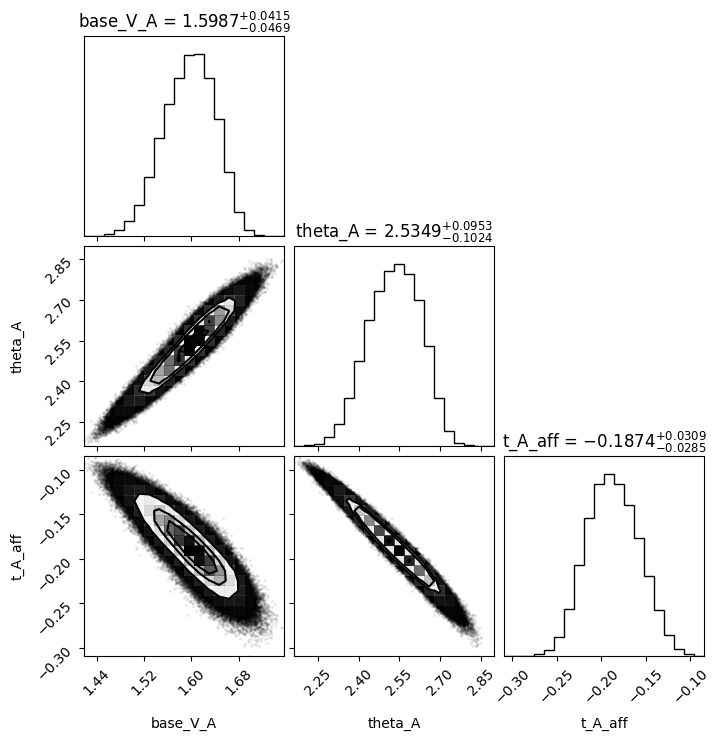

In [5]:
import corner
vp_samples = vp.sample(int(1e6))[0]
base_V_A_samp = vp_samples[:,0]
theta_A_samp = vp_samples[:,1]
t_A_aff_samp = vp_samples[:,2]

combined_samples = np.transpose(np.vstack((base_V_A_samp, theta_A_samp, t_A_aff_samp)))
param_labels = ['base_V_A', 'theta_A', 't_A_aff']
corner.corner (combined_samples, labels=param_labels, show_titles=True, title_fmt=".4f");


In [6]:
# from tqdm import tqdm
base_V_A_mean = np.mean(base_V_A_samp)
t_A_aff_mean = np.mean(t_A_aff_samp)
theta_A_mean = np.mean(theta_A_samp)

In [33]:
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm
import sys
def compute_aborts_for_res(row, new_V_A, T_trunc, t_A_aff_mean, base_V_A_mean, theta_A_mean):
    t_led = row['intended_fix'] - row['LED_onset_time']
    t_stim = row['intended_fix']

    if t_led == 0:
        trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff_mean, new_V_A, theta_A_mean)
        frac_of_aborts_till_LED = 0

        if T_trunc > t_stim:
            frac_of_aborts_till_stim = 0
        else:
            frac_of_aborts_till_stim = cum_A_t_fn(t_stim - t_A_aff_mean, new_V_A, theta_A_mean) / trunc_factor

        frac_of_aborts_btn_LED_and_stim = frac_of_aborts_till_stim - frac_of_aborts_till_LED
    else:
        trunc_factor_1 = 1 - cum_A_t_fn(T_trunc - t_A_aff_mean, base_V_A_mean, theta_A_mean)
        trunc_factor_2 = 1 - CDF_v_change_till_trunc_fn(T_trunc, t_led, base_V_A_mean, new_V_A, theta_A_mean, t_A_aff_mean)

        if t_led < T_trunc < t_stim:
            frac_of_aborts_till_LED = 0
            frac_of_aborts_till_stim = CDF_v_change_till_stim_trunc_adj_fn(t_stim, t_led, base_V_A_mean, new_V_A, theta_A_mean,\
                                                                            t_A_aff_mean, T_trunc, trunc_factor_2)
        elif T_trunc > t_stim:
            frac_of_aborts_till_LED = 0
            frac_of_aborts_till_stim = 0
        else:
            frac_of_aborts_till_LED = cum_A_t_fn(t_led - t_A_aff_mean, base_V_A_mean, theta_A_mean) / trunc_factor_1
            frac_of_aborts_till_stim = CDF_v_change_till_stim_trunc_adj_fn(t_stim, t_led, base_V_A_mean, new_V_A, theta_A_mean,\
                                                                            t_A_aff_mean, T_trunc, trunc_factor_1) # tf 2 -> ` tf1`

        frac_of_aborts_btn_LED_and_stim = frac_of_aborts_till_stim - frac_of_aborts_till_LED
        
    
    return frac_of_aborts_btn_LED_and_stim

# Serial computation over new_V_A_possible
# new_V_A_possible = np.arange(base_V_A_mean, base_V_A_mean + 0.5, 0.05)
new_V_A_possible = np.array([base_V_A_mean])
frac_of_aborts_btn_led_and_stim = np.zeros_like(new_V_A_possible)

df_sample = df.sample(1000)

# sample 1000 rows from df
for idx, new_V_A in enumerate(tqdm(new_V_A_possible, total=len(new_V_A_possible))):
    cdf_led_stim = Parallel(n_jobs=30)(
        delayed(compute_aborts_for_res)(row, new_V_A, T_trunc, t_A_aff_mean, base_V_A_mean, theta_A_mean) 
        for _, row in df_sample.iterrows()
    )
    frac_of_aborts_btn_led_and_stim[idx] = np.mean(cdf_led_stim)


100%|██████████| 1/1 [00:08<00:00,  8.62s/it]


In [ ]:
# from post_LED_censor_utils import PDF_t_v_change
# t_led = 1

# a = CDF_v_change_till_trunc_fn(T_trunc, t_led, base_V_A_mean, base_V_A_mean, theta_A_mean, t_A_aff_mean)
# b = cum_A_t_fn(T_trunc - t_A_aff_mean, base_V_A_mean, theta_A_mean)

# print(f'a: {a}, b: {b}, {np.abs(a-b)}')

a: 0.009342771331194863, b: 0.00934297926954235, 2.0793834748684958e-07


In [34]:
# from data
num_LED_on = df[ df['LED_trial'] == 1 ].shape[0]    

num_truncated_aborts = df[ (df['LED_trial'] == 1) & (df['timed_fix'] > T_trunc) & (df['timed_fix'] < df['intended_fix']) & \
                           (df['intended_fix'] - df['LED_onset_time'] < df['timed_fix']) ]

data_frac =  len(num_truncated_aborts) / num_LED_on
print(f'data frac aborts btn LED and stim = {data_frac}')

data frac aborts btn LED and stim = 0.08647738821138211


In [35]:
# from data
num_LED_off = len(df[ df['LED_trial'] == 0 ])

num_truncated_aborts_off = df[ (df['LED_trial'] == 0) & (df['timed_fix'] > T_trunc) & (df['timed_fix'] < df['intended_fix']) & \
                           (df['intended_fix'] - df['LED_onset_time'] < df['timed_fix']) ]

data_frac_off =  len(num_truncated_aborts_off) / num_LED_off
print(f'data frac aborts btn LED and stim off = {data_frac_off}')

data frac aborts btn LED and stim off = 0.04990912903676779


Text(0.5, 1.0, 'base v = 1.60, new v = 1.60, MEAN=0.12,true=0.09 ')

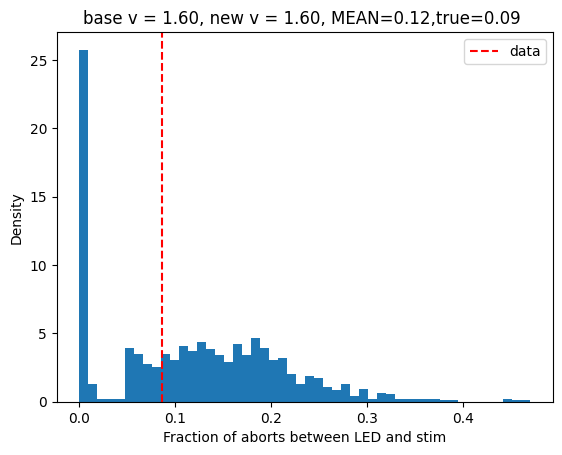

In [37]:
plt.hist(cdf_led_stim, bins=50, density=True); 
plt.axvline(data_frac, color='r', linestyle='--', label='data')
plt.legend()
plt.xlabel('Fraction of aborts between LED and stim')
plt.ylabel('Density')
plt.title(f'base v = {base_V_A_mean:.2f}, new v = {new_V_A_possible[0]:.2f}, MEAN={np.mean(cdf_led_stim):.2f},true={data_frac:.2f} ')

In [16]:
def truncated_rho(t,v,a):
    if t  <= T_trunc - t_A_aff_mean:
        return 0
    else:
        return rho_A_t_fn(t,v,a)

In [20]:
df_sample = df.sample(10000)
t_pts = np.arange(0, 3, 0.01)
pdf_n = np.zeros((len(df_sample), len(t_pts)))
# rechange idx of df_sample
df_sample = df_sample.reset_index(drop=True)
trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff_mean, base_V_A_mean, theta_A_mean)
for rid, row in df_sample.iterrows():
    t_led = row['intended_fix'] - row['LED_onset_time']
    for idx, t in enumerate(t_pts):
        if t <= t_led:
            pdf_n[rid,idx] = truncated_rho(t - t_A_aff_mean, base_V_A_mean, theta_A_mean) / trunc_factor
        else:
            pdf_n[rid, idx] = 0


In [21]:
pdf_n_avg = np.mean(pdf_n, axis=0)

frac to norm: 0.07670441306677851


Text(0.5, 1.0, 'pre-led, led off aborts')

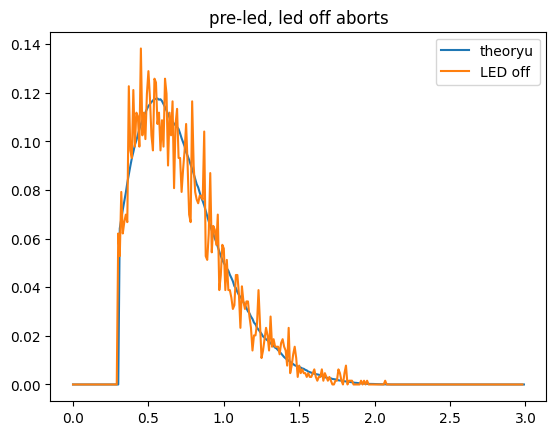

In [23]:
plt.plot(t_pts, pdf_n_avg, label='theoryu')



led_off = df[ (df['LED_trial'] == 0) & (df['timed_fix'] > T_trunc) & (df['timed_fix'] < df['intended_fix']) & \
                           (df['intended_fix'] - df['LED_onset_time'] > df['timed_fix']) ]['timed_fix'].values

frac_to_norm = len(led_off) / len(df[ df['LED_trial'] == 0 ])
led_off_hist, _ = np.histogram(led_off, bins=t_pts, density=True)
led_off_hist *= frac_to_norm
print(f'frac to norm: {frac_to_norm}')
plt.plot(t_pts[:-1], led_off_hist, label='LED off')

plt.legend()
plt.title('pre-led, led off aborts')

# btn led and stim

In [7]:
from post_LED_censor_utils import PDF_t_v_change


df_sample = df.sample(1000)
t_pts = np.arange(0, 3, 0.01)
pdf_n = np.zeros((len(df_sample), len(t_pts)))
# rechange idx of df_sample
df_sample = df_sample.reset_index(drop=True)
# trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff_mean, base_V_A_mean, theta_A_mean)
for rid, row in df_sample.iterrows():
    t_led = row['intended_fix'] - row['LED_onset_time']
    t_stim = row['intended_fix']

    for idx, t in enumerate(t_pts):
        if t <= T_trunc:
            pdf_n[rid,idx] = 0
        else:
            if t_led == 0:
                trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff_mean, base_V_A_mean, theta_A_mean)
                if t <= t_stim:
                    pdf_n[rid, idx] = rho_A_t_fn(t - t_A_aff_mean, base_V_A_mean, theta_A_mean) / trunc_factor
                else:
                    pdf_n[rid, idx] = 0
            else:
                trunc_factor_1 = 1 - cum_A_t_fn(T_trunc - t_A_aff_mean, base_V_A_mean, theta_A_mean)
                trunc_factor_2 = 1 - CDF_v_change_till_trunc_fn(T_trunc, t_led, base_V_A_mean, base_V_A_mean, theta_A_mean, t_A_aff_mean)
                if t <= t_stim:
                    if t <= t_led:
                        pdf_n[rid, idx] = rho_A_t_fn(t - t_A_aff_mean, base_V_A_mean, theta_A_mean) / trunc_factor_1
                    else:
                        pdf_n[rid, idx] = PDF_t_v_change(t, t_led, base_V_A_mean, base_V_A_mean, theta_A_mean, t_A_aff_mean) / trunc_factor_2
                else:
                    pdf_n[rid, idx] = 0

        # if t <= t_led:
        #     pdf_n[rid,idx] = truncated_rho(t - t_A_aff_mean, base_V_A_mean, theta_A_mean) / trunc_factor
        # if t > t_led and t <= t_stim:
        #     pdf_n[rid, idx] = PDF_t_v_change(t, t_led, base_V_A_mean, base_V_A_mean, theta_A_mean, t_A_aff_mean)
        # else:
        #     pdf_n[rid, idx] = 0


frac to norm: 0.1266135421035463
area under theory curve: 0.12908902382938087
area under data curve: 0.1266135421035463


/tmp/ipykernel_2677701/188759152.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(f'area under theory curve: {np.trapz(pdf_n_avg, t_pts)}')
/tmp/ipykernel_2677701/188759152.py:15: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(f'area under data curve: {np.trapz(led_off_hist, t_pts[:-1])}')


Text(0.5, 1.0, 'LED off aborts,  till t stim')

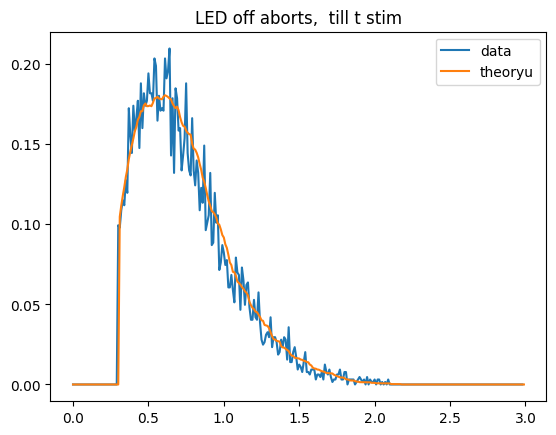

In [13]:
pdf_n_avg = np.mean(pdf_n, axis=0)
t_pts = np.arange(0, 3, 0.01)
led_off = df[ (df['LED_trial'] == 0) & (df['timed_fix'] > T_trunc) & (df['timed_fix'] < df['intended_fix']) ]['timed_fix'].values

frac_to_norm = len(led_off) / len(df[ df['LED_trial'] == 0 ])
led_off_hist, _ = np.histogram(led_off, bins=t_pts, density=True)
led_off_hist *= frac_to_norm
print(f'frac to norm: {frac_to_norm}')

plt.plot(t_pts[:-1], led_off_hist, label='data')

plt.plot(t_pts, pdf_n_avg, label='theoryu')

print(f'area under theory curve: {np.trapz(pdf_n_avg, t_pts)}')
print(f'area under data curve: {np.trapz(led_off_hist, t_pts[:-1])}')
plt.legend()
plt.title('LED off aborts,  till t stim')

# Led on pre-led

In [17]:
df_sample = df.sample(10000)
t_pts = np.arange(0, 3, 0.01)
pdf_n = np.zeros((len(df_sample), len(t_pts)))
# rechange idx of df_sample
df_sample = df_sample.reset_index(drop=True)
trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff_mean, base_V_A_mean, theta_A_mean)
for rid, row in df_sample.iterrows():
    t_led = row['intended_fix'] - row['LED_onset_time']
    for idx, t in enumerate(t_pts):
        if t <= t_led:
            pdf_n[rid,idx] = truncated_rho(t - t_A_aff_mean, base_V_A_mean, theta_A_mean) / trunc_factor
        else:
            pdf_n[rid, idx] = 0

frac to norm: 0.07723577235772358


Text(0.5, 1.0, 'Pre - LED, LED on aborts')

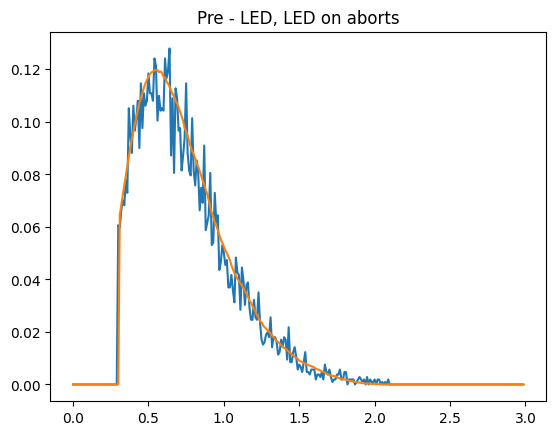

In [19]:
led_on = df[ (df['LED_trial'] == 1) & (df['timed_fix'] > T_trunc) & (df['timed_fix'] < df['intended_fix']) & \
                           (df['intended_fix'] - df['LED_onset_time'] > df['timed_fix']) ]['timed_fix'].values

frac_to_norm = len(led_on) / len(df[ df['LED_trial'] == 1 ])
led_off_hist, _ = np.histogram(led_off, bins=t_pts, density=True)
led_off_hist *= frac_to_norm
print(f'frac to norm: {frac_to_norm}')
plt.plot(t_pts[:-1], led_off_hist, label='LED off')


pdf_on_avg = np.mean(pdf_n, axis=0)
plt.plot(t_pts, pdf_on_avg, label='theoryu')
plt.title('Pre - LED, LED on aborts')

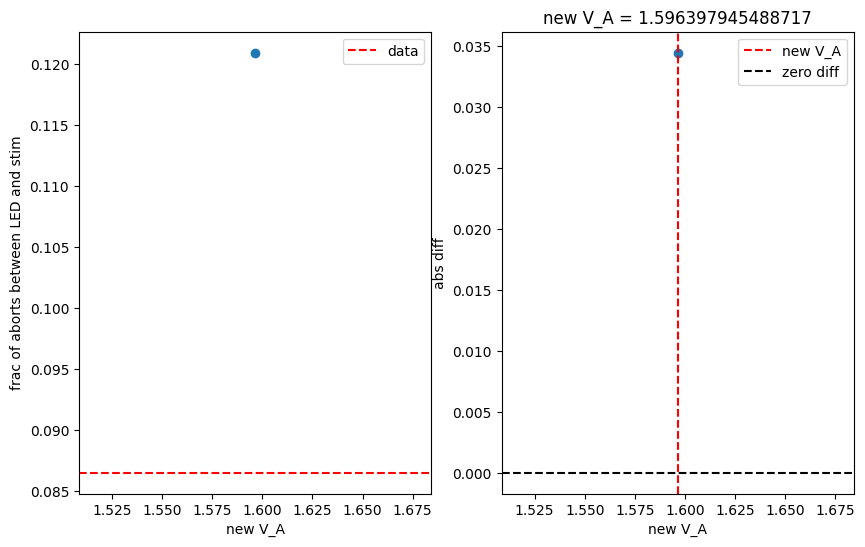

In [27]:
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.scatter(new_V_A_possible, frac_of_aborts_btn_led_and_stim)
plt.axhline(data_frac, color='r', linestyle='--', label='data')
plt.xlabel('new V_A')
plt.ylabel('frac of aborts between LED and stim')

plt.legend();

plt.subplot(1,2,2)
diff = frac_of_aborts_btn_led_and_stim - data_frac
plt.scatter(new_V_A_possible, np.abs(diff))

# close idx to zero in diff
idx = np.argmin(np.abs(diff))
plt.axvline(new_V_A_possible[idx], color='r', linestyle='--', label='new V_A')
plt.axhline(0, color='k', linestyle='--', label='zero diff')
plt.title(f'new V_A = {new_V_A_possible[idx]}')
plt.xlabel('new V_A')
plt.ylabel('abs diff')
plt.legend()